In [1]:
import nltk, re, pprint
from math import log
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from functools import partial
import dictionaries_rel
import dictionaries_pol
import csv
import numpy as np
#import pandas as pd
import modin.pandas as pd
import swifter

import warnings
warnings.filterwarnings("ignore")

In [17]:
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

In [3]:
def stem_search_terms (keyword_set):
    stemmed_keywords=[]
    ps = PorterStemmer()
    for keyword in keyword_set:
        stemmed_keywords.append(ps.stem(keyword))
    stemmed_keywords=set(stemmed_keywords)
    return stemmed_keywords


def text_to_nl (article):
    return_list=[]
    #wl = WordNetLemmatizer()
    ps = PorterStemmer()

    sentences=sent_tokenize(article)
    for sent in sentences:
        words = word_tokenize(sent.lower())
        words = nltk.pos_tag(words)
        a=[(ps.stem(i),j) for (i,j) in words]
        return_list.append(a)
    return return_list

In [4]:
def x_score(article, nouns, verbs, verbose=False):
    parse = text_to_nl(article)
    verb_places = []
    noun_places = []
    for sentence in range(len(parse)):
        verb_places+=[sentence for word in parse[sentence] if word[0] in verbs and word[1][0]=='V']
        noun_places+=[(sentence,noun[1]) for word in parse[sentence] for noun in nouns if word[0]==noun[0]]
        
    if verbose:
        print(verb_places, noun_places)

    if len(verb_places)==0: verb_places=[999]
    tot_score = 0
    for found_tuples in noun_places:
        dist = (min([(found_tuples[0]-i)**2 for i in verb_places]))
        score = found_tuples[1] * np.e**-(0.1*dist)
        tot_score += score
    return tot_score

In [5]:
buildings = stem_search_terms(dictionaries_rel.religious_buildings)
terms = stem_search_terms(dictionaries_rel.religious_terms)
verbs = stem_search_terms(dictionaries_rel.attack_terms)
verbs_sec = stem_search_terms(dictionaries_rel.kill_terms)

verbs = set(list(verbs)+list(verbs_sec)+['kill','shot'])
nouns = [(i,20) for i in buildings]+[(i,5) for i in terms]

In [6]:
def df_score(row, nouns=nouns, verbs=verbs, verbose=False):
    article = str(row.source_article) + ' ' + str(row.what)
    if verbose: 
        print("**********")
        print(article)
        print("**********")
        print(nouns, verbs)
    return x_score(article, nouns, verbs)

In [7]:
fill_scode = partial(df_score, nouns=nouns, verbs=verbs)

In [8]:
test_text='''Three Coptic Christians were found dead in a southern Egyptian village on Friday and police suspect they were killed by the same Moslem militants who gunned down 10 Coptic youths this week, security sources said. They said police found the bodies of fishermen Freig Oweidah Israel, his son Ibrahim and policeman William Bishara Khalil in the sugar cane fields of Kom al-Zuheir village near Abu Qurqas town, some 240 km (150 miles) south of Cairo. All three were members of Egypt\'s Coptic minority and the sources said they had been shot in the head last night by gunmen thought to belong to the militant Gama\'a al-Islamiya (Islamic Group) trying to transform Egypt into a strict Islamic state. Another article reported: (R, 1997-02-14): Three men were found dead on Friday in a southern Egyptian village just miles away from a church where suspected Moslem militants killed 10 Coptic youths this week, security sources said. They said police found the bodies of fishermen Freig Oweidah Israel and his son Ibrahim, both members of Egypt\'s Coptic minority, in the sugar cane fields of Kom al-Zuheir village near Abu Qurqas town, some 240 km (150 miles) south of Cairo. A third unidentified body was also found and all had been shot in the head, the sources said. Police said they had no information on whether the men were killed in a family feud or by Moslem militants waging a violent campaign to transform Egypt into a purist Islamic state'''

In [12]:
test_score = x_score(test_text, nouns=nouns, verbs=verbs)
assert 64.50<test_score<64.55

In [13]:
data_df = pd.read_parquet('data/raw_marisol.parquet')
data_df = data_df[~data_df.to_be_coded.isna()]

2025-03-18 15:49:14,054	INFO worker.py:1642 -- Started a local Ray instance.


In [15]:
data_df['xscore']=data_df.swifter.apply(df_score, axis=1)

In [16]:
data_df['actual'] = data_df.rep + data_df.building
data_df['actual'] = data_df['actual'].clip(upper=1)
data_df = data_df[~data_df.actual.isna()]

In [18]:
def boot_metrics(df, iters=1000, verbose=True, color1 = 'steelblue', color2 = 'deepskyblue', name_plot='rel'):
    np.random.seed(seed=42)
    warnings.filterwarnings("ignore")
    boot_aupr = []
    boot_auroc = []

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    ax1.legend(["ROC"])
    ax2.legend(["PR"])

    fpr, tpr, _ = roc_curve(data_df.actual, data_df.xscore)

    ddf = df._to_pandas() 

    for i in range(iters):
        if i%100==0 and verbose:
            print(i, end=' ')
        boot_df = ddf.sample(frac=1, replace=True)

        fpr, tpr, _ = roc_curve(boot_df.actual, boot_df.xscore)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name='X')
        roc_display.plot(ax=ax1, color=color2, alpha = .002)
        ax1.legend_ = None

        prec, recall, _ = precision_recall_curve(boot_df.actual, boot_df.xscore)
        pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
        pr_display.plot(ax=ax2, color=color2, alpha = .002)

        boot_aupr += [average_precision_score(boot_df.actual, boot_df.xscore)]
        boot_auroc += [roc_auc_score(boot_df.actual, boot_df.xscore)]


    fpr, tpr, _ = roc_curve(ddf.actual, ddf.xscore)
    
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name='X')

    prec, recall, _ = precision_recall_curve(ddf.actual, ddf.xscore)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

    roc_display.plot(ax=ax1, color=color1, alpha = 1)
    ax1.legend_ = None
    pr_display.plot(ax=ax2, color=color1, alpha = 1)

    aupr = average_precision_score(ddf.actual, ddf.xscore)
    auroc = roc_auc_score(ddf.actual, ddf.xscore)

    boot_aupr = sorted(boot_aupr)
    boot_auroc = sorted(boot_auroc)
    if verbose:
        print("Done")

    fig.savefig(f'{name_plot}.png',dpi=300)
    
    return fig, boot_aupr, boot_auroc, aupr, auroc

In [19]:
!pip freeze | grep matplotlib

matplotlib==3.8.0
matplotlib-inline==0.1.6


0 100 200 300 400 500 600 700 800 900 Done
AUROC: 0.8359014141222729, Boot CI: 0.836789660224933: 0.8041672324255609 -- 0.8651508701028071
AUPR: 0.48201805181653334, Boot CI: 0.4845856256124504: 0.420234519074491 -- 0.5420132257459392


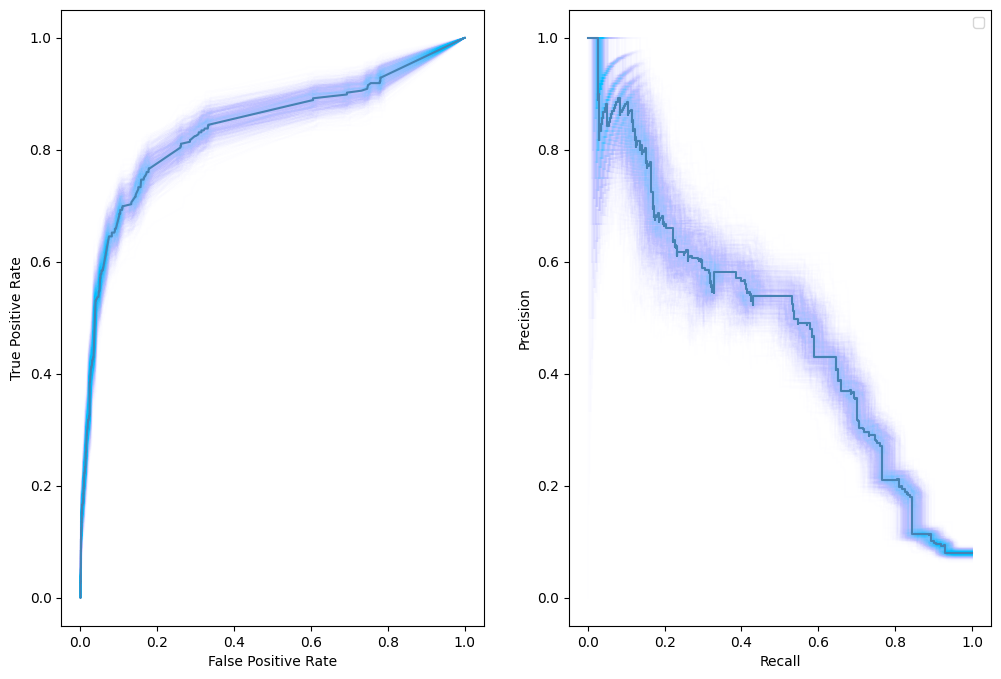

In [20]:
fig, boot_aupr, boot_auroc, aupr, auroc = boot_metrics(data_df, iters=1000, name_plot='rel')

print (f"AUROC: {auroc}, Boot CI: {boot_auroc[500]}: {boot_auroc[25]} -- {boot_auroc[975]}")
print (f"AUPR: {aupr}, Boot CI: {boot_aupr[500]}: {boot_aupr[25]} -- {boot_aupr[975]}")



# Full political coding

In [23]:
deco = pd.read_csv('data/DECO_v.1.0.csv')
ex_pol = pd.read_csv('data/pol_scored.csv')
ex_pol['actual']=0
ex_pol.loc[ex_pol.id.isin(deco.id),'actual']=1

In [24]:
actor1 = stem_search_terms(dictionaries_pol.political_actor) 
actor2 = stem_search_terms(dictionaries_pol.political_actor2)
verbs = list(dictionaries_pol.political_seconds)
verbs += list(dictionaries_rel.attack_terms) + list(dictionaries_rel.kill_terms)
verbs += ['kill','disrupt','die','vote','elect']
verbs = set(stem_search_terms(verbs))
nouns = [(i,20) for i in actor1]+[(i,5) for i in actor2]
nouns

[('candid', 20),
 ('disenfranchis', 20),
 ('referendum', 20),
 ('caucu', 20),
 ('elector', 20),
 ('elect', 20),
 ('enfranchis', 20),
 ('gerrymand', 20),
 ('vote', 20),
 ('franchis', 20),
 ('constitu', 20),
 ('voter', 20),
 ('ballot', 20),
 ('incumb', 20),
 ('franchiz', 20),
 ('plebiscit', 20),
 ('runoff', 20),
 ('canvass', 20),
 ('run-off', 20),
 ('wing', 5),
 ('anarchist', 5),
 ('left-w', 5),
 ('liber', 5),
 ('communist', 5),
 ('right-w', 5)]

In [29]:
def df_score_x(row, nouns=nouns, verbs=verbs, verbose=False):
    article = str(row.source_article) + ' ' + str(row.what)
    if verbose: 
        print("**********")
        print(article)
        print("**********")
        print(nouns, verbs)
    return x_score(article, nouns, verbs)

In [30]:
ex_pol['xscore']=ex_pol.swifter.apply(df_score_x, axis=1)

0 100 200 300 400 500 600 700 800 900 Done


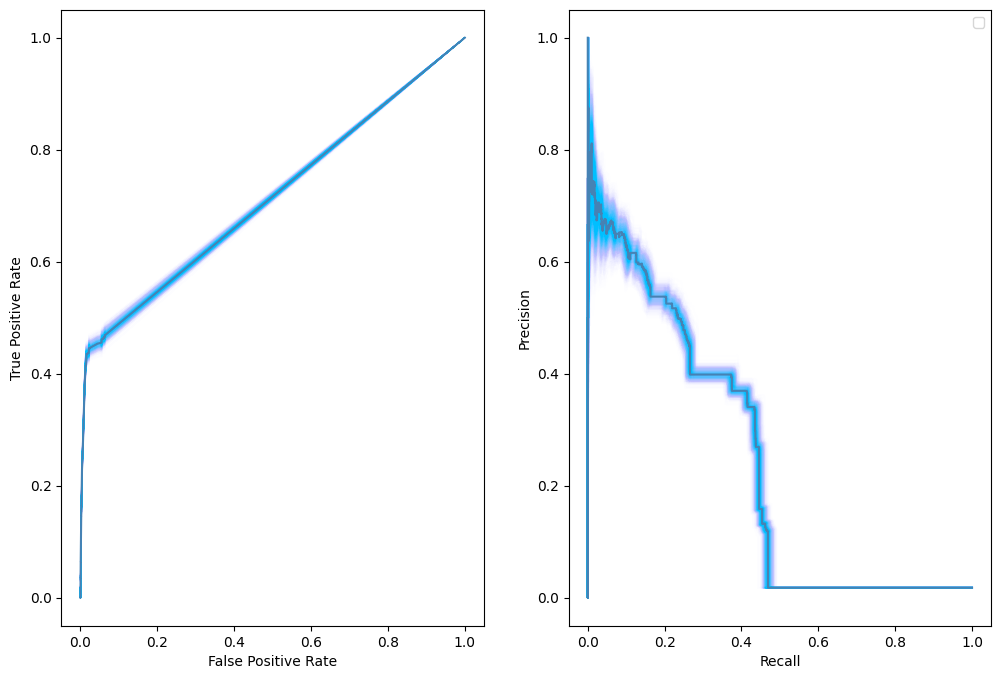

AUROC: 0.7139454523515364, Boot CI: 0.7140002471888741: 0.7070589389857765 -- 0.7223189167800865
AUPR: 0.23930778731574553, Boot CI: 0.23955026815404773: 0.22450440743075945 -- 0.2556383058647643


In [31]:
fig, boot_aupr, boot_auroc, aupr, auroc = boot_metrics(ex_pol, iters=1000, name_plot='pol')

plt.show()

print (f"AUROC: {auroc}, Boot CI: {boot_auroc[500]}: {boot_auroc[25]} -- {boot_auroc[975]}")
print (f"AUPR: {aupr}, Boot CI: {boot_aupr[500]}: {boot_aupr[25]} -- {boot_aupr[975]}")

In [34]:
ex_pol.to_csv('data/coded_pol_handcoded.csv')
data_df.to_csv('data/coded_rel_handcoded.csv')